# Gaussian Process Models for Quantitative Finance

# Jupyter Notebook Python Companion Code for Chapter 2: Covariance Kernels

**Authors**: Mike Ludkovski and Jimmy Risk

The following notebook provides code to reproduce most of the plots in **Chapter 2**.  Please first go through the supplement for Chapter 2, as we assume the reader is familiar with those basics.

We similarly use the `easyGPR` helper functions in the script `easyGPR_helper.py` as mentioned in the Chapter 1 notebook.  Please ensure ``easyGPR_helper.py`` is in the same directory as any code you are running.

## Imports

In [1]:
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt

In [2]:
# Hide notebook warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
from easyGPR_helper import set_gpytorch_settings, GPRModel

set_gpytorch_settings()

## Prior Kernel Comparison

``gpytorch`` contains many [covariance kernels by default](https://docs.gpytorch.ai/en/stable/kernels.html).  Here, we give code to reproduce **Figure 2.1** which plots $k(x,x')$ along with three sample paths for the SE, Exponential (Matern-1/2), Quadratic, and Period kernels. For all kernels we set a lengthscale of $\ell_{len} = 1$.

In [4]:
from gpytorch.kernels import ScaleKernel, PolynomialKernel, PeriodicKernel, RBFKernel
from gpytorch.kernels import CosineKernel, MaternKernel, LinearKernel

# SE Kernel
k1 = (
    ScaleKernel(RBFKernel())
)
k1.base_kernel.lengthscale=1

# Exponential Kernel (Matern-1/2)
k2 = (
    ScaleKernel(MaternKernel(nu=0.5))
)
k2.base_kernel.lengthscale=1

# Quadratic Kernel
k3 = (
    ScaleKernel(PolynomialKernel(power=2))
)
k3.base_kernel.offset = torch.tensor([0.0])

# Polynomial Kernel
k4 = (
    ScaleKernel(PeriodicKernel())
)
k4.base_kernel.lengthscale=2
k4.base_kernel.period_length=1

Now we plot the shape of $k(x,x')$ keeping $x$ fixed,  along with three sample paths for a zero-mean GP with the respective kernel, $f \sim GP(0, k)$.

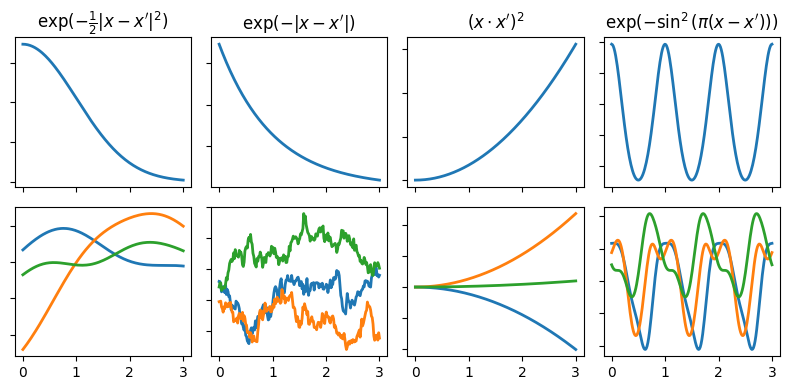

In [5]:
kernels_list = [k1, k2, k3, k4]
titles = [r"$\exp(-\frac{1}{2}|x-x'|^2)$", r"$\exp(-|x-x'|)$", r"$(x\cdot x')^2$", r"$\exp(-\sin^2(\pi(x-x')))$"]

# Set seed for sample path generation
seed = 82345

torch.manual_seed(seed)
np.random.seed(seed)

# Initialize a figure for the subplot panel
fig, axes = plt.subplots(2, 4, figsize=(8, 4))

# Range for x-axis 
x_range = torch.linspace(0, 3, 200)
x_range_np = x_range.cpu().numpy().flatten()

# Loop through each kernel to create plots
for i, (kernel, title) in enumerate(zip(kernels_list, titles)):
    
    # First row: Plot kernel functions with thicker lines
    if kernel.base_kernel.has_lengthscale:
        K = kernel(x_range, torch.tensor([0.0]))
        K_np = K.cpu().numpy().flatten()
        axes[0, i].plot(x_range_np, K_np, linewidth=2)
    else:
        K = kernel(x_range, torch.tensor([1.0]))
        K_np = K.cpu().numpy().flatten()
        axes[0, i].plot(x_range_np, K_np, linewidth=2)
    
    # Hide y-axis and x-axis values for the top row
    axes[0, i].set_yticklabels([])
    
    axes[0, i].set_xticklabels([])
    axes[0, i].set_xticks([0, 1, 2, 3])
    
    # Set title for the first row
    axes[0, i].set_title(title)
    
    for j in range(3):
        sim_model = GPRModel(kernel = kernel.cuda(), scale_x=False)
        y_sim = sim_model.simulate(x_range_np, method='posterior', return_type = "numpy")
        axes[1,i].plot(x_range_np, y_sim, linewidth=2)
    axes[1, i].set_yticklabels([])
    axes[1, i].set_xticks([0, 1, 2, 3])
    axes[1, i].set_xticklabels(['0', '1', '2', '3'])    

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


## Varying Hyperparameters for Common Kernels

**Figure 2.2** and **Figure 2.3** are produced in the next two chunks.  These are the same style as Figure 2.1, but illustrate the effect of varying hyperparameters for some common kernel families.  Each hyperparameter configuration $\theta_j$ appears in the left panel as $k(x,x'; \theta_j)$, along with a GP sample path for that $\theta_j$ on the right panel.

### Comparing Matern Kernels

This first chunk produces **Figure 2.2**, comparing Mat\'ern families across their smoothness parameter $\nu$.  

In [6]:
# Define Matern Kernels with different parameters nu
k1 = (
    ScaleKernel(MaternKernel(nu=0.5))
)
k1.base_kernel.lengthscale = 1.0

k2 = (
    ScaleKernel(MaternKernel(nu=1.5))
)
k2.base_kernel.lengthscale = 1.0

k3 = (
    ScaleKernel(MaternKernel(nu=2.5))
)
k3.base_kernel.lengthscale = 1.0

k4 = (
    ScaleKernel(RBFKernel())
)
k4.base_kernel.lengthscale = 1.0

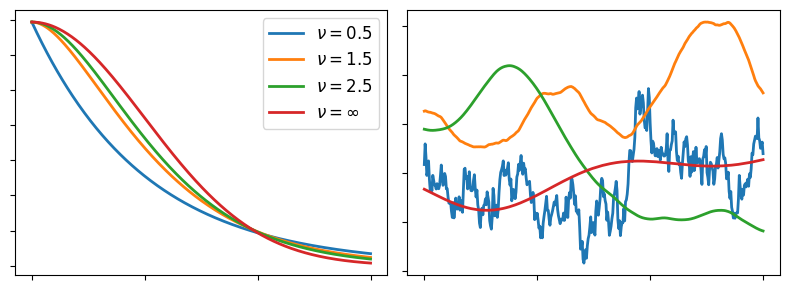

In [7]:
# For plotting
kernels_list = [k1, k2, k3, k4]
titles = [r"$\nu = 0.5$", r"$\nu = 1.5$", r"$\nu = 2.5$", r"$\nu = \infty$"]

# Reproducibility for sample paths
seed = 8

torch.manual_seed(seed)
np.random.seed(seed)

# Initialize a figure for the subplot panel
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Range for x-axis (0 to 3 initially, can be adjusted to 0 to 5 if necessary)
x_range = torch.linspace(0, 3, 400)
x_range_np = x_range.cpu().numpy().flatten()

# Loop through each kernel to create plots
for i, (kernel, title) in enumerate(zip(kernels_list, titles)):

    # Left panel
    K = kernel(x_range, torch.tensor([0.0]))
    K_np = K.cpu().numpy().flatten()
    axes[0].plot(x_range_np, K_np, linewidth=2, label=title)

    # Hide y-axis and x-axis values for the top row
    axes[0].set_yticklabels([])

    axes[0].set_xticklabels([])
    axes[0].set_xticks([0, 1, 2, 3])

    for j in range(1):
        sim_model = GPRModel(kernel=kernel.cuda(), scale_x=False)
        y_sim = sim_model.simulate(x_range, method='posterior', return_type="numpy")
        axes[1].plot(x_range_np, y_sim, linewidth=2)
    axes[1].set_yticklabels([])
    axes[1].set_xticks([0, 1, 2, 3])
    #axes[1].set_xticklabels(['0', '1', '2', '3'])
    axes[1].set_xticklabels([])

axes[0].legend(loc='upper right', fontsize=12, labelspacing=0.5, framealpha=0.8)
# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### Comparing Rational Quadratic Families

The rational quadratic family $$k_{RQ}(r; \alpha, \ell_{\text{len}}) = \left( 1 + \frac{r^2}{2 \alpha \ell_{\text{len}}^2} \right)^{-\alpha}$$ is parametrized via $\alpha$. $\alpha=1$ is the Cauchy kernel

In [8]:
from gpytorch.kernels import RQKernel

rq_k1 = (
    ScaleKernel(RQKernel())
)
rq_k1.base_kernel.alpha=0.2
rq_k1.base_kernel.lengthscale=1

rq_k2 = (
    ScaleKernel(RQKernel())
)
rq_k2.base_kernel.alpha=1
rq_k2.base_kernel.lengthscale=1

rq_k3 = (
    ScaleKernel(RQKernel())
)
rq_k3.base_kernel.alpha=5
rq_k3.base_kernel.lengthscale=1

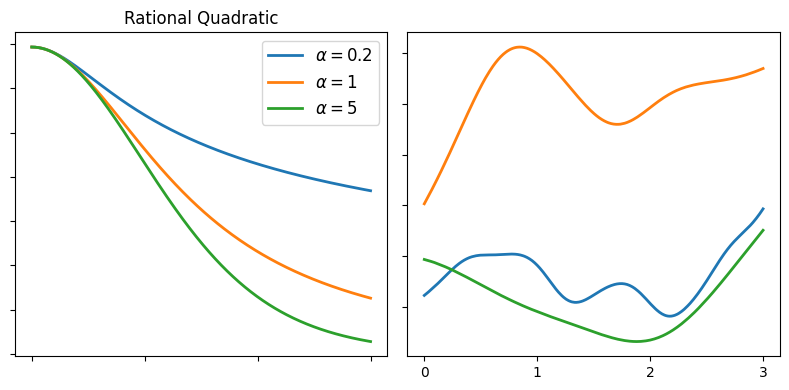

In [9]:
rq_kernels_list = [rq_k1, rq_k2, rq_k3]
rq_titles = [r"$\alpha = 0.2$", r"$\alpha = 1$", r"$\alpha = 5$"]

# For reproducibility
seed = 8234

torch.manual_seed(seed)
np.random.seed(seed)

# Initialize a figure for the subplot panel
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Range for x-axis 
x_range = torch.linspace(0, 3, 400)
x_range_np = x_range.cpu().numpy().flatten()

# Loop through each kernel to create plots
for i, (kernel, title) in enumerate(zip(rq_kernels_list, rq_titles)):
    # Left panel
    K = kernel(x_range, torch.tensor([0.0]))
    K_np = K.cpu().numpy().flatten()
    axes[0].plot(x_range_np, K_np, linewidth=2, label=title)

    # Hide y-axis and x-axis values for the top row
    axes[0].set_yticklabels([])

    axes[0].set_xticklabels([])
    axes[0].set_xticks([0, 1, 2, 3])

    for j in range(1):
        sim_model = GPRModel(kernel=kernel.cuda(), scale_x=False)
        y_sim = sim_model.simulate(x_range, method='posterior', return_type="numpy")
        axes[1].plot(x_range_np, y_sim, linewidth=2)
    axes[1].set_yticklabels([])
    axes[1].set_xticks([0, 1, 2, 3])
    axes[1].set_xticklabels(['0', '1', '2', '3'])

axes[0].legend(loc='upper right', fontsize=12, labelspacing=0.5, framealpha=0.8)
axes[0].set_title("Rational Quadratic")

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()

### Comparing Power Exponential Families

#### Defining Kernel Functions (Power Exponential Kernel)

The (isotropic) power exponential kernel $k(r) = \exp\left(-(r/\ell_{\text{len}})^\beta\right)$ is not available in ``gpytorch``.  The following code illustrates how to create your own kernel with the package.  

* Since this kernel is stationary and defined by its lengthscale, we can use ``has_lengthscale = True`` to have ``gpytorch`` to automatically handle anything ``lengthscale`` related.
* The $\beta$ parameter needs to be handled by hand (in this case, it is called ``alpha``).
* The ``forward`` method handles the actual kernel calculation, which is straightforward using the built in ``covar_dist`` (giving the matrix of $d(x,x')$) and then using vectorized operations.

Ability to implement a ``prior`` for hyperparameters is not used in this analysis, but included for completeness sake.

In [10]:
from gpytorch.kernels.kernel import Kernel
from gpytorch.priors import Prior
from gpytorch.constraints import Interval
from typing import Optional

class PowerExponentialKernel(Kernel):
    """
    Power Exponential Kernel defined as exp(-(r/l)^alpha).

    * r is the distance between inputs x1 and x2.
    * l is a lengthscale parameter.
    * alpha is a parameter satisfying 0 < alpha <= 2.
    """

    has_lengthscale = True

    def __init__(
            self,
            alpha_prior: Optional[Prior] = None,
            alpha_constraint: Optional[Interval] = None,
            **kwargs
    ):
        super(PowerExponentialKernel, self).__init__(**kwargs)
        if alpha_constraint is None:
            alpha_constraint = Interval(1e-5, 2+1e-5, initial_value=1.5)

        ard_num_dims = kwargs.get("ard_num_dims", 1)
        self.register_parameter(
            name="raw_alpha", parameter=torch.nn.Parameter(torch.ones(*self.batch_shape, 1, ard_num_dims))
        )

        if alpha_prior is not None:
            if not isinstance(alpha_prior, Prior):
                raise TypeError("Expected gpytorch.priors.Prior but got " + type(alpha_prior).__name__)
            self.register_prior(
                "alpha_prior",
                alpha_prior,
                lambda m: m.alpha,
                lambda m, v: m._set_alpha(v),
            )

        self.register_constraint("raw_alpha", alpha_constraint)

    @property
    def alpha(self):
        return self.raw_alpha_constraint.transform(self.raw_alpha)

    @alpha.setter
    def alpha(self, value):
        self._set_alpha(value)

    def _set_alpha(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_alpha)
        self.initialize(raw_alpha=self.raw_alpha_constraint.inverse_transform(value))

    def forward(self, x1, x2, diag=False, **params):
        # Calculate the distance
        distance = self.covar_dist(x1, x2, diag=diag, **params)
        # Apply the Power Exponential kernel function
        return torch.exp(-torch.pow(distance.div(self.lengthscale), self.alpha))

Now, we can make the Power Exponential panel like we did for RQ, varying $\alpha$:

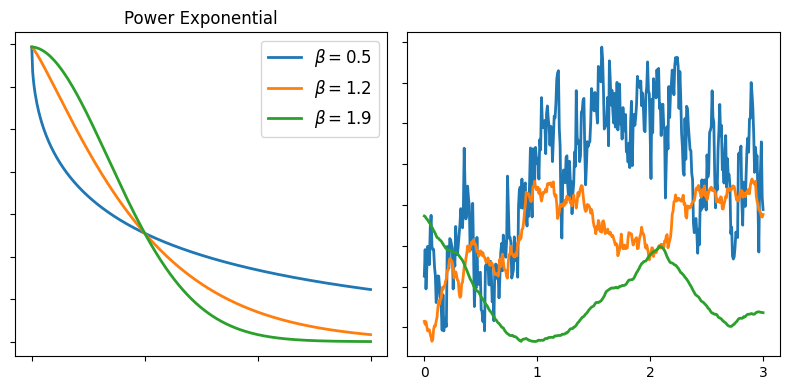

In [11]:
pow_k1 = (
    ScaleKernel(PowerExponentialKernel())
)
pow_k1.base_kernel.alpha = 0.5
pow_k1.base_kernel.lengthscale = 1.0

pow_k2 = (
    ScaleKernel(PowerExponentialKernel())
)
pow_k2.base_kernel.alpha = 1.2
pow_k2.base_kernel.lengthscale = 1.0

pow_k3 = (
    ScaleKernel(PowerExponentialKernel())
)
pow_k3.base_kernel.alpha = 1.9
pow_k3.base_kernel.lengthscale = 1.0


pow_kernels_list = [pow_k1, pow_k2, pow_k3]
pow_titles = [r"$\beta = 0.5$", r"$\beta = 1.2$", r"$\beta = 1.9$"]

# Initialize a figure for the subplot panel
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Range for x-axis 
x_range = torch.linspace(0, 3, 400)
x_range_np = x_range.cpu().numpy().flatten()

# Loop through each kernel to create plots
for i, (kernel, title) in enumerate(zip(pow_kernels_list, pow_titles)):
    # Left panel
    K = kernel(x_range, torch.tensor([0.0]))
    K_np = K.cpu().numpy().flatten()
    axes[0].plot(x_range_np, K_np, linewidth=2, label=title)

    # Hide y-axis and x-axis values for the top row
    axes[0].set_yticklabels([])

    axes[0].set_xticklabels([])
    axes[0].set_xticks([0, 1, 2, 3])

    for j in range(1):
        sim_model = GPRModel(kernel=kernel.cuda(), scale_x=False)
        y_sim = sim_model.simulate(x_range, method='posterior', return_type="numpy")
        axes[1].plot(x_range_np, y_sim, linewidth=2)
    axes[1].set_yticklabels([])
    axes[1].set_xticks([0, 1, 2, 3])
    axes[1].set_xticklabels(['0', '1', '2', '3'])

axes[0].legend(loc='upper right', fontsize=12, labelspacing=0.5, framealpha=0.8)
axes[0].set_title("Power Exponential")

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()

### Comparing Periodic Kernel Families

The next figure has the same flavor as the last figure, comparing differing lengthscales for two periodic kernels $k_{per}(r; p, \ell_{\text{len}})=  \exp\left(-2 \frac{\sin^2(\frac{\pi}{p} r)}{\ell_{\text{len}}^2}\right)$ each with period $p=1$.

In [12]:
per_k1 = (
    ScaleKernel(PeriodicKernel())
)
per_k1.base_kernel.period_length = 1
per_k1.base_kernel.lengthscale = 0.25

per_k2 = (
    ScaleKernel(PeriodicKernel())
)
per_k2.base_kernel.period_length = 1
per_k2.base_kernel.lengthscale = 2

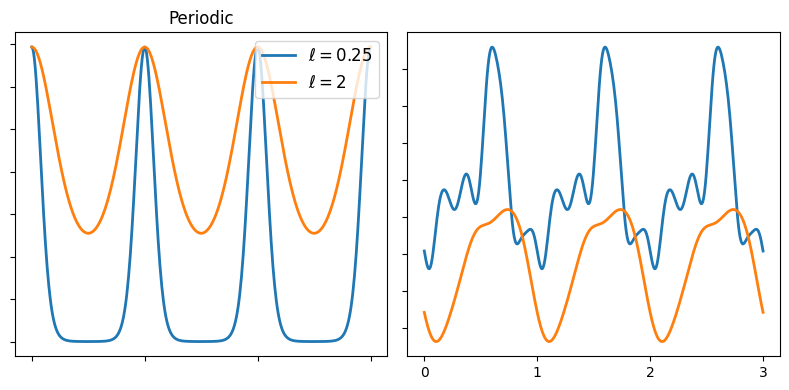

In [13]:
per_kernels_list = [per_k1, per_k2]
per_titles = [r"$\ell = 0.25$", r"$\ell = 2$"]


# Initialize a figure for the subplot panel
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Range for x-axis 
x_range = torch.linspace(0, 3, 400)
x_range_np = x_range.cpu().numpy().flatten()

# Loop through each kernel to create plots
for i, (kernel, title) in enumerate(zip(per_kernels_list, per_titles)):
    # Left panel
    K = kernel(x_range, torch.tensor([0.0]))
    K_np = K.cpu().numpy().flatten()
    axes[0].plot(x_range_np, K_np, linewidth=2, label=title)

    # Hide y-axis and x-axis values for the top row
    axes[0].set_yticklabels([])

    axes[0].set_xticklabels([])
    axes[0].set_xticks([0, 1, 2, 3])

    for j in range(1):
        sim_model = GPRModel(kernel=kernel.cuda(), scale_x=False)
        y_sim = sim_model.simulate(x_range, method='posterior', return_type="numpy")
        axes[1].plot(x_range_np, y_sim, linewidth=2)
    axes[1].set_yticklabels([])
    axes[1].set_xticks([0, 1, 2, 3])
    axes[1].set_xticklabels(['0', '1', '2', '3'])

axes[0].legend(loc='upper right', fontsize=12, labelspacing=0.5, framealpha=0.8)
axes[0].set_title("Periodic")

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()

## GP Model Selection

The following chunks illustrate GP model selection, fitting the synthetic training dataset $\mathcal{D}_{40}$ of size 40 to $k_1 = \eta^2 k_{\text{Mat-5/2}}, k_2 = \eta^2 k_{\text{Per}}$, and $k_3 = \eta_1^2 k_{\text{Poly2}} + \eta_2^2 k_{\text{Per}}$.  The underlying response is $f(x) = -0.1 x^2 + \sin(3x).$

This reproduces **Figure 2.4** and **Table 2.1** in the text. 

First, regenerate the synthetic dataset (same code as Chapter 1)

In [14]:
# Set the random seed for reproducibility
seed = 127
torch.manual_seed(seed)
np.random.seed(seed)


# Define the underlying true function
def f(x):
    return -0.1 * x ** 2 + np.sin(3 * x)


# Parameters
N_low = 20  # Total number of samples for low N scenario
N_high = 40  # Total number of samples for high N scenario
noise = 0.4  # Noise level

x_train_low = np.linspace(1, 5, N_low, endpoint=False)

y_train_low = f(x_train_low) + np.random.normal(0, noise, x_train_low.shape)

x_train_high_diff = np.hstack((
    np.linspace(1.1, 1.9, 5, endpoint=True),
    np.linspace(3.0, 4.0, 5, endpoint=False),
    np.linspace(3.0, 4.0, 5, endpoint=False),
    np.repeat(5.0, 5),
))

x_train_high = np.hstack((
    x_train_low,
    x_train_high_diff
))

y_train_high = np.hstack((
    y_train_low,
    f(x_train_high_diff) + np.random.normal(0, noise, x_train_high_diff.shape)
))
# Reshape the training data to 2D array for the model input
x_train_low = x_train_low.reshape(-1, 1)
x_train_high = x_train_high.reshape(-1, 1)

x_train = x_train_high
y_train = y_train_high

Next, define the three kernels and fit the models.  Here we do not scale the data (``scale_x = False``) since the scale is already reasonable and it helps with interpretation.  In particular, the periodic kernel especially benefits from a reasonable initial estimate for $p$.

This code also reports the maximum log likelihood, number of parameters, and BIC scores (for **Table 2.1**).

In [15]:
# Matern-5/2 kernel
k1 = (
    ScaleKernel(MaternKernel(nu=2.5))
)

m1 = GPRModel(train_x=x_train, train_y=y_train, kernel=k1, scale_x = False) 
m1.fit_model(training_iterations=1000, lr=0.1)


# Periodic Kernel
k2 = (
    ScaleKernel(PeriodicKernel())
)
# Initial value for period estimate
k2.base_kernel.period_length = 2*torch.pi/3

m2 = GPRModel(train_x=x_train, train_y=y_train, kernel=k2, scale_x = False)  
m2.fit_model(training_iterations=1000, lr=0.01)


# Composite additive Kernel
k3 = (
    ScaleKernel(PolynomialKernel(power=2)) + 
    ScaleKernel(PeriodicKernel())
)
k3.kernels[1].base_kernel.period_length = 2*torch.pi/3

m3 = GPRModel(train_x=x_train, train_y=y_train, kernel=k3, scale_x = False) 
m3.fit_model(training_iterations=1000, lr=0.01)

Fitting complete.
--- 
--- final mll: -0.7713
--- num_params: 4
--- BIC: 38.2302
Fitting complete.
--- 
--- final mll: -1.2293
--- num_params: 5
--- BIC: 58.3947
Fitting complete.
--- 
--- final mll: -0.6719
--- num_params: 7
--- BIC: 39.7867


GPRModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): Positive()
    )
  )
  (mean_module): ConstantMean()
  (kernel): AdditiveKernel(
    (kernels): ModuleList(
      (0): ScaleKernel(
        (base_kernel): PolynomialKernel(
          (raw_offset_constraint): Positive()
        )
        (raw_outputscale_constraint): Positive()
      )
      (1): ScaleKernel(
        (base_kernel): PeriodicKernel(
          (raw_lengthscale_constraint): Positive()
          (raw_period_length_constraint): Positive()
        )
        (raw_outputscale_constraint): Positive()
      )
    )
  )
)


Next, produce **Figure 2.4** which compares the posterior mean and 95% bands for the 3 kernels on the test set spanning $[0,7]$.

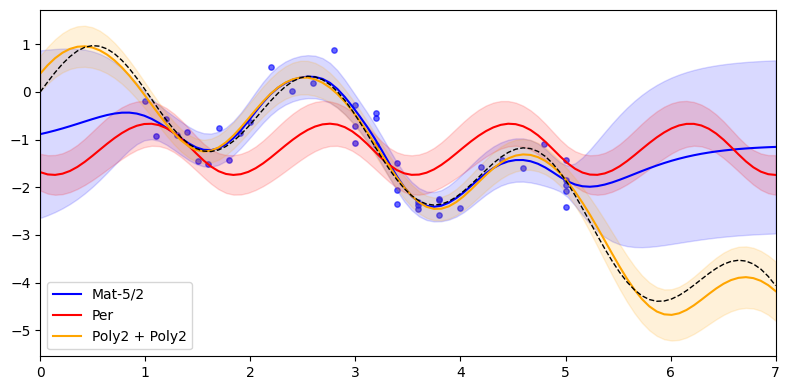

In [16]:
# Make predictions
x_test = torch.linspace(0, 7, 100)
x_test_np = x_test.cpu().numpy().flatten()  # Convert x_test to a numpy array for plotting

predictions1 = m1.make_predictions(x_test.unsqueeze(1), type="f", return_type="numpy")
predictions2 = m2.make_predictions(x_test.unsqueeze(1), type="f", return_type="numpy")
predictions3 = m3.make_predictions(x_test.unsqueeze(1), type="f", return_type="numpy")

# Initialize a figure for the subplot panel
fig, ax = plt.subplots(1, 1, figsize=(8, 4), sharex=True)  # Add sharey=True to share the y-axis

# y-axis limits for plotting
y_min = -8.0
y_max = 1.5

# Scatterplot of data
ax.scatter(x_train.flatten(), y_train, label=None, color='blue', s=15, marker='o', alpha=0.6)


for predictions, color,label in zip([predictions1, predictions2, predictions3],
                                    ['blue','red','orange'],
                                    ['Mat-5/2', "Per", "Poly2 + Poly2"]):
    ax.plot(x_test_np, predictions.mean, label=label, color=color, linewidth=1.5)
    ax.fill_between(x_test_np, predictions.mean - 1.96 * np.sqrt(predictions.variance),
                    predictions.mean + 1.96 * np.sqrt(predictions.variance), alpha=0.15, color=color,
                    label=None)

# True f_0(x)
ax.plot(x_test_np, f(x_test_np), '--', label=None, color='black', linewidth=1)
ax.set_xlim([x_test_np.min(), x_test_np.max()])

ax.legend(loc='lower left', fontsize=10, labelspacing=0.5, framealpha=0.8)

plt.tight_layout()

plt.show()

### Hyperparameters 

Now we look at the respective hyperparameters for the three above models. These MLEs appear in **Table 2.1** of the book.  Note that ``gpytorch`` reports $\hat{\sigma}_{\epsilon}^2$, so taking square roots gives the values in Table 2.1 (e.g.$\sqrt{0.143445} = 0.3787413$).  Otherwise, the estimates should be identical (and as mentioned previously, are on the original scale of the dataset).

In [17]:
m1.get_hyperparameters_df()

,Hyperparameter Name,Estimate
0,likelihood.noise_covar.noise,0.143445
1,mean_module.constant,-1.122929
2,kernel.outputscale,0.859082
3,kernel.base_kernel.lengthscale,0.634520


In [18]:
m2.get_hyperparameters_df()

,Hyperparameter Name,Estimate
0,likelihood.noise_covar.noise,0.588563
1,mean_module.constant,-1.196270
2,kernel.outputscale,0.256852
3,kernel.base_kernel.lengthscale,1.445476
4,kernel.base_kernel.period_length,1.717355


In [19]:
m3.get_hyperparameters_df()

,Hyperparameter Name,Estimate
0,likelihood.noise_covar.noise,0.136183
1,mean_module.constant,0.032364
2,kernel.kernels.0.outputscale,0.011060
3,kernel.kernels.0.base_kernel.offset,0.093528
4,kernel.kernels.1.outputscale,1.226553
5,kernel.kernels.1.base_kernel.lengthscale,4.102998
6,kernel.kernels.1.base_kernel.period_length,2.165862


Lastly, ``GPRModel`` class has a built in ``get_LOOCV()`` method which uses the efficient computation.  This completes **Table 2.1**.

In [20]:
print(f"LOOCV RMSE for m1: {m1.get_LOOCV().item():.3f}")
print(f"LOOCV RMSE for m2: {m2.get_LOOCV().item():.3f}")
print(f"LOOCV RMSE for m3: {m3.get_LOOCV().item():.3f}")

LOOCV RMSE for m1: 0.436
LOOCV RMSE for m2: 0.819
LOOCV RMSE for m3: 0.397


---
## License

This notebook is licensed under the [MIT License](https://github.com/jimmyrisk/GP-Quant/blob/main/LICENSE).

Copyright (c) 2024 Jimmy Risk and Mike Ludkovski